## Computer Aided Gastrointestinal Disease Detection using PyTorch.

### Transfer learning.

In [1]:
import os
import random
import splitfolders
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from typing import Tuple, Dict, List

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models



In [2]:
# Setup device-agnostic code

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
data_folder = r'D:\Miniconda\pytorch\data_folder'
os.listdir(data_folder)

['test', 'train', 'valid']

In [4]:
# splitfolders.ratio(input= data_folder, ratio=(0.8, 0.1, 0.1) , move=True)

In [5]:
train_dir = data_folder + '\\train\\'
valid_dir = data_folder + '\\valid\\'
test_dir  = data_folder + '\\test\\'

print(train_dir)
print(valid_dir)
print(test_dir)

D:\Miniconda\pytorch\data_folder\train\
D:\Miniconda\pytorch\data_folder\valid\
D:\Miniconda\pytorch\data_folder\test\


In [6]:
def create_dataloaders(
    train_dir: str,
    valid_dir: str,
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=os.cpu_count()
):

    train_data = datasets.ImageFolder(train_dir, transform=transform)
    valid_data = datasets.ImageFolder(valid_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True)
    
    valid_dataloader = DataLoader(valid_data,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True)
    
    test_dataloader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=True)

    return train_dataloader, valid_dataloader, test_dataloader, class_names

In [7]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [8]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [9]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          valid_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "valid_loss": [],
               "valid_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        valid_loss, valid_acc = test_step(model=model,
                                dataloader=valid_dataloader,
                                loss_fn=loss_fn,
                                device=device)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"valid_loss: {valid_loss:.4f} | "
            f"valid_acc: {valid_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### Transfer learning.

### 1. Resnet18.

In [10]:
from torchvision import models

weights   = models.ResNet18_Weights.DEFAULT
transforms= weights.transforms() 
resnet18  = models.resnet18(weights= weights).to(device)


train_dataloader, valid_dataloader, test_dataloader, class_names= create_dataloaders(
                                                                  train_dir=train_dir,
                                                                  valid_dir=valid_dir,
                                                                  test_dir=test_dir,
                                                                  transform=transforms,
                                                                  batch_size=8,
                                                                  num_workers=os.cpu_count()) 


print(train_dataloader, valid_dataloader, test_dataloader, class_names)


for param in resnet18.parameters():
    param.requires_grad = False
    

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


resnet18.fc = nn.Sequential(nn.Dropout(p=0.2, inplace=True), 
                                    nn.Linear(in_features=512, 
                                    out_features=len(class_names),
                                    bias=True))

from torchinfo import summary
print(summary(model= resnet18, 
        input_size=(1, 3, 64, 64), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) )

resnet18.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet18.parameters(), lr=0.001)


# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train the model
resnet18_results = train(model= resnet18, 
                    train_dataloader=train_dataloader,
                    valid_dataloader=valid_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn, 
                    epochs=5,
                    device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time-start_time)/60:.3f} minutes")

<torch.utils.data.dataloader.DataLoader object at 0x00000148F065CDC0> <torch.utils.data.dataloader.DataLoader object at 0x00000148F065CA90> <torch.utils.data.dataloader.DataLoader object at 0x00000148F065C8E0> ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 64, 64]       [1, 8]               --                   Partial
├─Conv2d (conv1)                         [1, 3, 64, 64]       [1, 64, 32, 32]      (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 32, 32]      [1, 64, 32, 32]      (128)                False
├─ReLU (relu)                            [1, 64, 32, 32]      [1, 64, 32, 32]      --                   --
├─MaxPool2d (maxpool)                    [1, 64, 32, 32]      [1, 64, 16, 16]      --     

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1583 | train_acc: 0.5847 | valid_loss: 0.6083 | valid_acc: 0.7800
Epoch: 2 | train_loss: 0.7265 | train_acc: 0.7388 | valid_loss: 0.4403 | valid_acc: 0.8450
Epoch: 3 | train_loss: 0.6521 | train_acc: 0.7575 | valid_loss: 0.3881 | valid_acc: 0.8725
Epoch: 4 | train_loss: 0.5944 | train_acc: 0.7753 | valid_loss: 0.4458 | valid_acc: 0.8175
Epoch: 5 | train_loss: 0.5901 | train_acc: 0.7744 | valid_loss: 0.4149 | valid_acc: 0.8450
Total training time: 4.817 minutes


### 2. VGG16.

In [11]:
from torchvision import models

weights   = models.VGG16_Weights.DEFAULT
transforms= weights.transforms() 
vgg16  = models.vgg16(weights= weights).to(device)

train_dataloader, valid_dataloader, test_dataloader, class_names= create_dataloaders(
                                                                  train_dir=train_dir,
                                                                  valid_dir=valid_dir,
                                                                  test_dir=test_dir,
                                                                  transform=transforms,
                                                                  batch_size=8,
                                                                  num_workers=os.cpu_count()) 


print(train_dataloader, valid_dataloader, test_dataloader, class_names)



for param in vgg16.features.parameters():
    param.requires_grad = False
    

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


vgg16.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), 
                                    nn.Linear(in_features=25088 , 
                                    out_features=len(class_names),
                                    bias=True))

from torchinfo import summary
print(summary(model= vgg16, 
        input_size=(1, 3, 64, 64), 
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) )

vgg16.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vgg16.parameters(), lr=0.001)


# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train the model
vgg16_results = train(model= vgg16, 
                train_dataloader=train_dataloader,
                valid_dataloader=valid_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn, 
                epochs=5,
                device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time-start_time)/60:.3f} minutes")

<torch.utils.data.dataloader.DataLoader object at 0x00000148F0663040> <torch.utils.data.dataloader.DataLoader object at 0x00000148F064C640> <torch.utils.data.dataloader.DataLoader object at 0x00000148F0654FA0> ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [1, 3, 64, 64]       [1, 8]               --                   Partial
├─Sequential (features)                  [1, 3, 64, 64]       [1, 512, 2, 2]       --                   False
│    └─Conv2d (0)                        [1, 3, 64, 64]       [1, 64, 64, 64]      (1,792)              False
│    └─ReLU (1)                          [1, 64, 64, 64]      [1, 64, 64, 64]      --                   --
│    └─Conv2d (2)                        [1, 64, 64, 64]      [1, 64, 64, 64]      (36,928

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2831 | train_acc: 0.7572 | valid_loss: 1.2717 | valid_acc: 0.8025
Epoch: 2 | train_loss: 0.3826 | train_acc: 0.9241 | valid_loss: 1.3664 | valid_acc: 0.8125
Epoch: 3 | train_loss: 0.1716 | train_acc: 0.9613 | valid_loss: 1.5652 | valid_acc: 0.7925
Epoch: 4 | train_loss: 0.1045 | train_acc: 0.9819 | valid_loss: 1.4125 | valid_acc: 0.8225
Epoch: 5 | train_loss: 0.1027 | train_acc: 0.9769 | valid_loss: 1.6861 | valid_acc: 0.7950
Total training time: 10.140 minutes


#### 3. AlexNet model.

In [12]:
from torchvision import models

weights   = models.AlexNet_Weights.DEFAULT
transforms= weights.transforms() 
alexnet  = models.alexnet(weights= weights).to(device)


train_dataloader, valid_dataloader, test_dataloader, class_names= create_dataloaders(
                                                                  train_dir=train_dir,
                                                                  valid_dir=valid_dir,
                                                                  test_dir=test_dir,
                                                                  transform=transforms,
                                                                  batch_size=8,
                                                                  num_workers=os.cpu_count()) 


print(train_dataloader, valid_dataloader, test_dataloader, class_names)


for param in alexnet.features.parameters():
    param.requires_grad = False
    

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


alexnet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), 
                                    nn.Linear(in_features=9216 , 
                                    out_features=len(class_names),
                                    bias=True))

from torchinfo import summary
print(summary(model= alexnet, 
        input_size=(1, 3, 64, 64), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]))


alexnet.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=alexnet.parameters(), lr=0.001)


# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train the model
alexnet_results = train(model= alexnet, 
                    train_dataloader=train_dataloader,
                    valid_dataloader=valid_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn, 
                    epochs=5,
                    device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time-start_time)/60:.3f} minutes")

<torch.utils.data.dataloader.DataLoader object at 0x00000148FA1ACA60> <torch.utils.data.dataloader.DataLoader object at 0x00000148FA1A14C0> <torch.utils.data.dataloader.DataLoader object at 0x00000148FA1A16A0> ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [1, 3, 64, 64]       [1, 8]               --                   Partial
├─Sequential (features)                  [1, 3, 64, 64]       [1, 256, 1, 1]       --                   False
│    └─Conv2d (0)                        [1, 3, 64, 64]       [1, 64, 15, 15]      (23,296)             False
│    └─ReLU (1)                          [1, 64, 15, 15]      [1, 64, 15, 15]      --                   --
│    └─MaxPool2d (2)                     [1, 64, 15, 15]      [1, 64, 7, 7]        --     

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3311 | train_acc: 0.7372 | valid_loss: 2.1294 | valid_acc: 0.7425
Epoch: 2 | train_loss: 0.5546 | train_acc: 0.8881 | valid_loss: 1.0285 | valid_acc: 0.8200
Epoch: 3 | train_loss: 0.3733 | train_acc: 0.9200 | valid_loss: 1.4096 | valid_acc: 0.8225
Epoch: 4 | train_loss: 0.2618 | train_acc: 0.9434 | valid_loss: 1.2178 | valid_acc: 0.8475
Epoch: 5 | train_loss: 0.1706 | train_acc: 0.9603 | valid_loss: 1.5045 | valid_acc: 0.8200
Total training time: 4.490 minutes


#### 4.MobileNet.

In [13]:
from torchvision import models

weights    = models.MobileNet_V2_Weights.DEFAULT
transforms = weights.transforms() 
mobilenet  = models.mobilenet_v2(weights= weights).to(device)

train_dataloader, valid_dataloader, test_dataloader, class_names= create_dataloaders(
                                                                  train_dir=train_dir,
                                                                  valid_dir=valid_dir,
                                                                  test_dir=test_dir,
                                                                  transform=transforms,
                                                                  batch_size=8,
                                                                  num_workers=os.cpu_count()) 


print(train_dataloader, valid_dataloader, test_dataloader, class_names)


for param in mobilenet.features.parameters():
    param.requires_grad = False
    

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


mobilenet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), 
                                     nn.Linear(in_features=1280 , 
                                     out_features=len(class_names),
                                     bias=True))

from torchinfo import summary
print(summary(model= mobilenet, 
             input_size=(1, 3, 64, 64), 
             col_names=["input_size", "output_size", "num_params", "trainable"],
             col_width=20,
             row_settings=["var_names"]))


mobilenet.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=mobilenet.parameters(), lr=0.001)


# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train the model
mobilenet_results = train(model= mobilenet, 
                    train_dataloader=train_dataloader,
                    valid_dataloader=valid_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn, 
                    epochs=5,
                    device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time-start_time)/60:.3f} minutes")

<torch.utils.data.dataloader.DataLoader object at 0x00000148969D2C10> <torch.utils.data.dataloader.DataLoader object at 0x00000148969D2D60> <torch.utils.data.dataloader.DataLoader object at 0x00000148969D29D0> ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [1, 3, 64, 64]       [1, 8]               --                   Partial
├─Sequential (features)                       [1, 3, 64, 64]       [1, 1280, 2, 2]      --                   False
│    └─Conv2dNormActivation (0)               [1, 3, 64, 64]       [1, 32, 32, 32]      --                   False
│    │    └─Conv2d (0)                        [1, 3, 64, 64]       [1, 32, 32, 32]      (864)                False
│    │    └─BatchNorm2d (1)                   [1, 32, 32, 32] 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0990 | train_acc: 0.6666 | valid_loss: 0.5814 | valid_acc: 0.8475
Epoch: 2 | train_loss: 0.6524 | train_acc: 0.7897 | valid_loss: 0.4530 | valid_acc: 0.8475
Epoch: 3 | train_loss: 0.5620 | train_acc: 0.8078 | valid_loss: 0.4118 | valid_acc: 0.8650
Epoch: 4 | train_loss: 0.5360 | train_acc: 0.8103 | valid_loss: 0.3611 | valid_acc: 0.8725
Epoch: 5 | train_loss: 0.4972 | train_acc: 0.8222 | valid_loss: 0.3462 | valid_acc: 0.8750
Total training time: 4.473 minutes


In [16]:
models = (vgg16, alexnet, resnet18, mobilenet)

scores=[]
for model in models:
    model.eval()  

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            result= f"{100*(correct / total):.2f}"
        scores.append(result)
            


        print(f'Test Accuracy of on the test images: {result}')

Test Accuracy of on the test images: 76.25
Test Accuracy of on the test images: 82.00
Test Accuracy of on the test images: 83.00
Test Accuracy of on the test images: 86.50


In [17]:
names = ["vgg16", "alexnet", "resnet18", "mobilenet"]

models_compare= pd.DataFrame(scores, index=[names], columns=["Accuracy"])

models_compare


,Accuracy
vgg16,76.25
alexnet,82.00
resnet18,83.00
mobilenet,86.50


In [19]:
def plot_loss_curves(results: Dict[str, List[float]]):
    # Get the loss values of the results dictionary (training and valid)
    loss = results['train_loss']
    valid_loss = results['valid_loss']

    # Get the accuracy values of the results dictionary (training and valid)
    accuracy = results['train_acc']
    valid_accuracy = results['valid_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, valid_loss, label='valid_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, valid_accuracy, label='valid_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

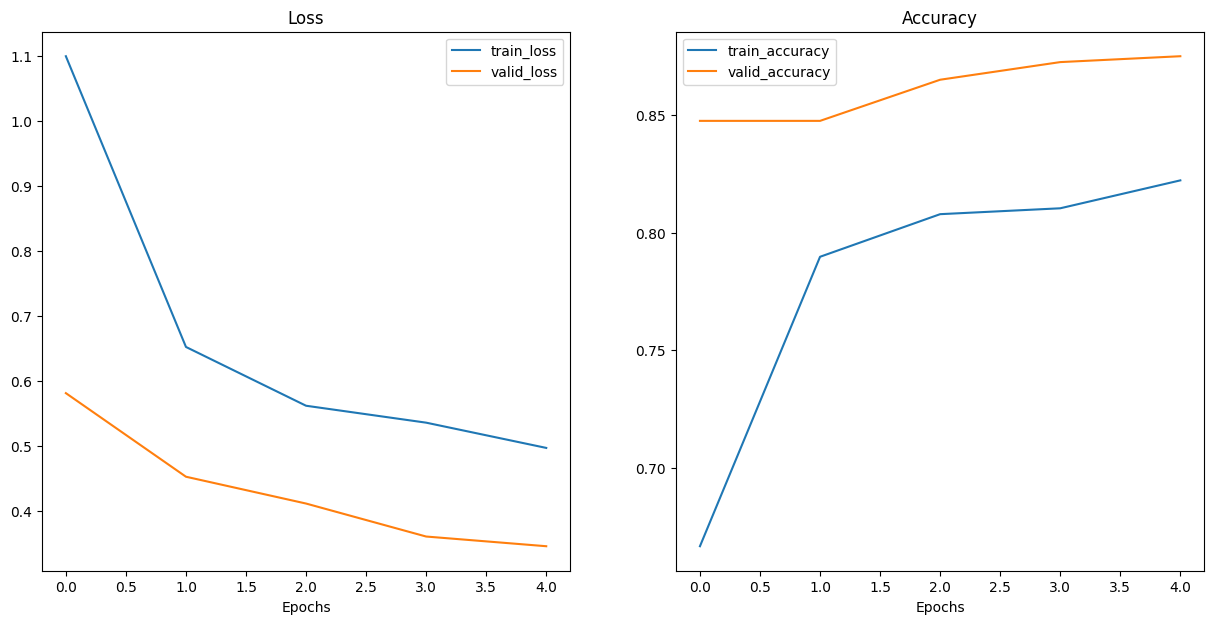

In [20]:
plot_loss_curves(mobilenet_results)